In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import random
import os


import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


VOCAB_SIZE = 10000  
MAX_LEN = 200       
HIDDEN_SIZE = 64    
NUM_CLASSES = 2     
LEARNING_RATE = 0.001

Running on: cuda


In [ ]:


def plot_loss_and_accuracy(history, norm_type, save_prefix="plot"):
    epochs = np.arange(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss plot
    axes[0].plot(epochs, history["train_loss"], label=f"Train Loss {norm_type}")
    axes[0].plot(epochs, history["val_loss"], linestyle="--", label=f"Val Loss {norm_type}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Training & Validation Loss ({norm_type})")
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(epochs, history["train_acc"], label=f"Train Acc {norm_type}")
    axes[1].plot(epochs, history["val_acc"], linestyle="--", label=f"Val Acc {norm_type}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"Training & Validation Accuracy ({norm_type})")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_{norm_type.lower()}_loss_acc.png", dpi=200)
    plt.show()

def plot_combined_loss(hist_bn, hist_ln, save_prefix="plot"):
    epochs = np.arange(1, len(hist_bn["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # BatchNorm Loss
    axes[0].plot(epochs, hist_bn["train_loss"], label="Train Loss BatchNorm")
    axes[0].plot(epochs, hist_bn["val_loss"], linestyle="--", label="Val Loss BatchNorm")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss (BatchNorm)")
    axes[0].legend()

    # LayerNorm Loss
    axes[1].plot(epochs, hist_ln["train_loss"], label="Train Loss LayerNorm")
    axes[1].plot(epochs, hist_ln["val_loss"], linestyle="--", label="Val Loss LayerNorm")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Training & Validation Loss (LayerNorm)")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_combined_loss.png", dpi=200)
    plt.show()

def plot_combined_accuracy(hist_bn, hist_ln, save_prefix="plot"):
    epochs = np.arange(1, len(hist_bn["train_acc"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # BatchNorm Accuracy
    axes[0].plot(epochs, hist_bn["train_acc"], label="Train Acc BatchNorm")
    axes[0].plot(epochs, hist_bn["val_acc"], linestyle="--", label="Val Acc BatchNorm")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Training & Validation Accuracy (BatchNorm)")
    axes[0].legend()

    # LayerNorm Accuracy
    axes[1].plot(epochs, hist_ln["train_acc"], label="Train Acc LayerNorm")
    axes[1].plot(epochs, hist_ln["val_acc"], linestyle="--", label="Val Acc LayerNorm")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training & Validation Accuracy (LayerNorm)")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_combined_accuracy.png", dpi=200)
    plt.show()

def plot_sensitivity_batch_size(results_by_batch, save_name="sensitivity_batch.png"):
    batches = sorted(results_by_batch.keys())
    ln_vals = [results_by_batch[b]["layernorm"] for b in batches]
    bn_vals = [results_by_batch[b]["batchnorm"] for b in batches]

    plt.figure()
    plt.plot(batches, ln_vals, marker='o', label="LayerNorm")
    plt.plot(batches, bn_vals, marker='o', label="BatchNorm")
    plt.xlabel("Batch size")
    plt.ylabel("Final Validation Accuracy")
    plt.title("Sensitivity to Batch Size")
    plt.xscale("log", base=2)
    plt.xticks(batches, batches)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.savefig(save_name, dpi=200)
    plt.show()

def plot_global_grad_norm(history, norm_type, save_name="global_grad_norm.png"):
    steps, norms = zip(*history["global_grad_norms"])
    plt.figure()
    plt.semilogy(steps, norms, label=f"Global Grad Norm {norm_type}")
    plt.xlabel("Training Step")
    plt.ylabel("Global L2 Gradient Norm (log scale)")
    plt.title(f"Global Gradient Norm vs Training Step ({norm_type})")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.savefig(f"{norm_type.lower()}_{save_name}", dpi=200)
    plt.show()

def plot_layer_grad_violin(hist_snapshots_ln, hist_snapshots_bn, save_name="layer_grad_violin.png"):
    epochs = sorted(set(hist_snapshots_ln.keys()) & set(hist_snapshots_bn.keys()))
    for epoch in epochs:
        data_ln = hist_snapshots_ln[epoch]
        data_bn = hist_snapshots_bn[epoch]
        layers = sorted(set(data_ln.keys()) & set(data_bn.keys()))

        fig, ax = plt.subplots(figsize=(12, 6))
        positions = []
        violin_data = []
        pos = 1
        ticks = []
        for layer in layers:
            violin_data.append(data_ln[layer])  # LN
            positions.append(pos)
            pos += 1
            violin_data.append(data_bn[layer])  # BN
            positions.append(pos)
            pos += 1
            ticks.append((pos - 1.5))
        parts = ax.violinplot(violin_data, positions=positions, showextrema=False)

        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor('orange' if i % 2 == 0 else 'blue')
            pc.set_alpha(0.7)

        ax.set_xticks(ticks)
        ax.set_xticklabels(layers, rotation=45, ha="right")
        ax.set_title(f"Layer-wise Gradient Distribution (Epoch {epoch}) - LN (left) vs BN (right)")
        ax.set_ylabel("Gradient values")
        ax.set_xlabel("Layer")

        plt.tight_layout()
        plt.savefig(f"{save_name}_epoch{epoch}.png", dpi=200)
        plt.show()

In [ ]:
class LSTM_Norm_Model(nn.Module):
    def __init__(self, norm_type='none'):
        super().__init__()
        self.norm_type = norm_type.lower()

        #Embedding Layer: 
        self.embedding = nn.Embedding(VOCAB_SIZE, HIDDEN_SIZE)

        #LSTM Layer 1
        self.lstm1 = nn.LSTM(HIDDEN_SIZE, HIDDEN_SIZE, batch_first=True)

        #Norm Layer
        if self.norm_type == 'batch':
        
            self.norm = nn.BatchNorm1d(HIDDEN_SIZE)
        elif self.norm_type == 'layer':
            self.norm = nn.LayerNorm(HIDDEN_SIZE)
        else:
            self.norm = nn.Identity()

        self.relu = nn.ReLU()

        #LSTM Layer 2
        self.lstm2 = nn.LSTM(HIDDEN_SIZE, HIDDEN_SIZE, batch_first=True)

        #Classifier (Positive/Negative)
        self.fc = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, x):
        # x shape: [Batch, Seq_Len] (Indices)

        # Embed: [Batch, Seq] -> [Batch, Seq, Hidden]
        x = self.embedding(x)

        out, _ = self.lstm1(x)

        # Apply Normalization
        if self.norm_type == 'batch':
            # Flatten Batch and Sequence dimensions
            N, L, C = out.shape
            out = out.reshape(N * L, C)
            out = self.norm(out)
            out = out.reshape(N, L, C)
        else:
            out = self.norm(out)

        out = self.relu(out)
        out, _ = self.lstm2(out)

        # Classification on last time step
        last_out = out[:, -1, :]
        logits = self.fc(last_out)
        return logits

In [ ]:
def load_imdb_data():
    print("Downloading/Loading IMDB data...")
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

    
    x_train = pad_sequences(x_train, maxlen=MAX_LEN, padding='pre', truncating='pre')
    x_test = pad_sequences(x_test, maxlen=MAX_LEN, padding='pre', truncating='pre')

    train_data = TensorDataset(torch.LongTensor(x_train), torch.LongTensor(y_train))
    test_data = TensorDataset(torch.LongTensor(x_test), torch.LongTensor(y_test))

    return train_data, test_data

train_ds, test_ds = load_imdb_data()

Downloading/Loading IMDB data...
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def train_model(norm_type, batch_size, epochs=5, capture_grads=False):
    set_seed(42)

    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    model = LSTM_Norm_Model(norm_type).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'global_grad_norms': []
    }
    snapshots = {}

    print(f"\n--- Training {norm_type.upper()} | Batch Size: {batch_size} ---")
    global_step = 0

    for epoch in range(1, epochs + 1):
        model.train()
        r_loss, correct, total = 0, 0, 0

        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()

        
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item() ** 2
            total_norm = total_norm ** 0.5
            history["global_grad_norms"].append((global_step, total_norm))

        
            if capture_grads and i == 0 and (epoch == 1 or epoch == 3 or epoch == epochs):
                snapshots[epoch] = {}
                if model.lstm1.weight_ih_l0.grad is not None:
                    snapshots[epoch]["LSTM1_In"] = model.lstm1.weight_ih_l0.grad.cpu().numpy().flatten()
                if model.lstm2.weight_ih_l0.grad is not None:
                    snapshots[epoch]["LSTM2_In"] = model.lstm2.weight_ih_l0.grad.cpu().numpy().flatten()
                if model.fc.weight.grad is not None:
                    snapshots[epoch]["FC"] = model.fc.weight.grad.cpu().numpy().flatten()

            optimizer.step()
            r_loss += loss.item()
            _, pred = torch.max(out, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            global_step += 1

    
        model.eval()
        v_loss, v_correct, v_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                out = model(inputs)
                loss = criterion(out, labels)
                v_loss += loss.item()
                _, pred = torch.max(out, 1)
                v_total += labels.size(0)
                v_correct += (pred == labels).sum().item()


        history["train_loss"].append(r_loss / len(loader))
        history["val_loss"].append(v_loss / len(test_loader))
        history["train_acc"].append(correct / total)
        history["val_acc"].append(v_correct / v_total)

        print(f"Ep {epoch}: Train Loss {history['train_loss'][-1]:.3f} | Val Acc {history['val_acc'][-1]:.3f}")

    return history, snapshots

>>> PART A: Running Main Comparison (BN vs LN)...

--- Training BATCH | Batch Size: 64 ---
Ep 1: Train Loss 0.593 | Val Acc 0.761
Ep 2: Train Loss 0.428 | Val Acc 0.809
Ep 3: Train Loss 0.351 | Val Acc 0.833
Ep 4: Train Loss 0.297 | Val Acc 0.850
Ep 5: Train Loss 0.254 | Val Acc 0.852

--- Training LAYER | Batch Size: 64 ---
Ep 1: Train Loss 0.614 | Val Acc 0.754
Ep 2: Train Loss 0.515 | Val Acc 0.798
Ep 3: Train Loss 0.368 | Val Acc 0.834
Ep 4: Train Loss 0.294 | Val Acc 0.853
Ep 5: Train Loss 0.237 | Val Acc 0.861

>>> Generating Comparison Plots...


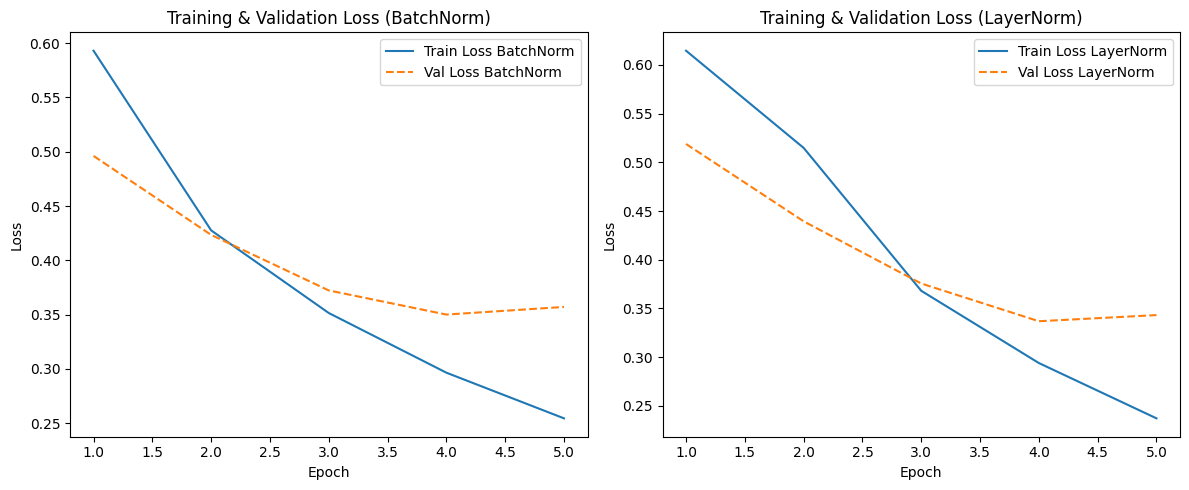

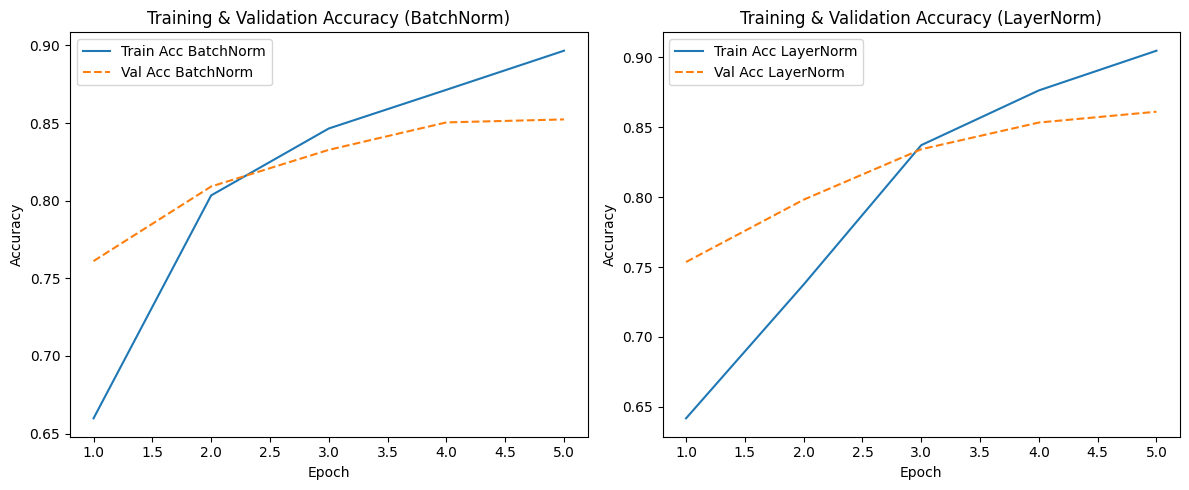

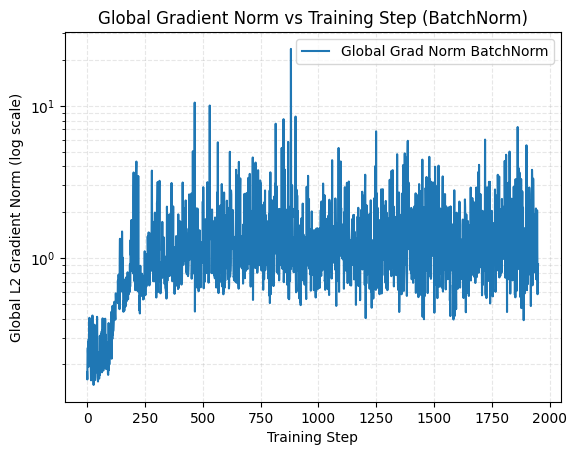

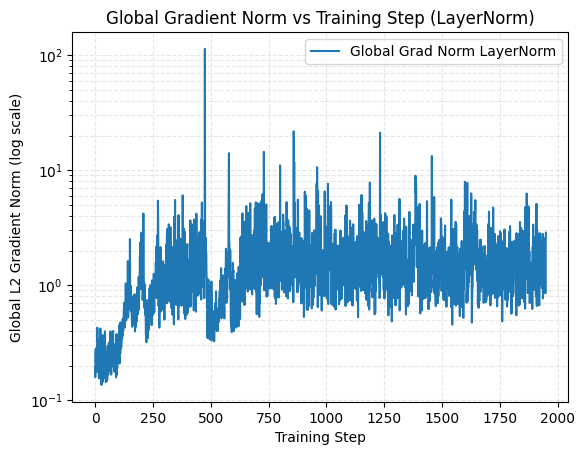

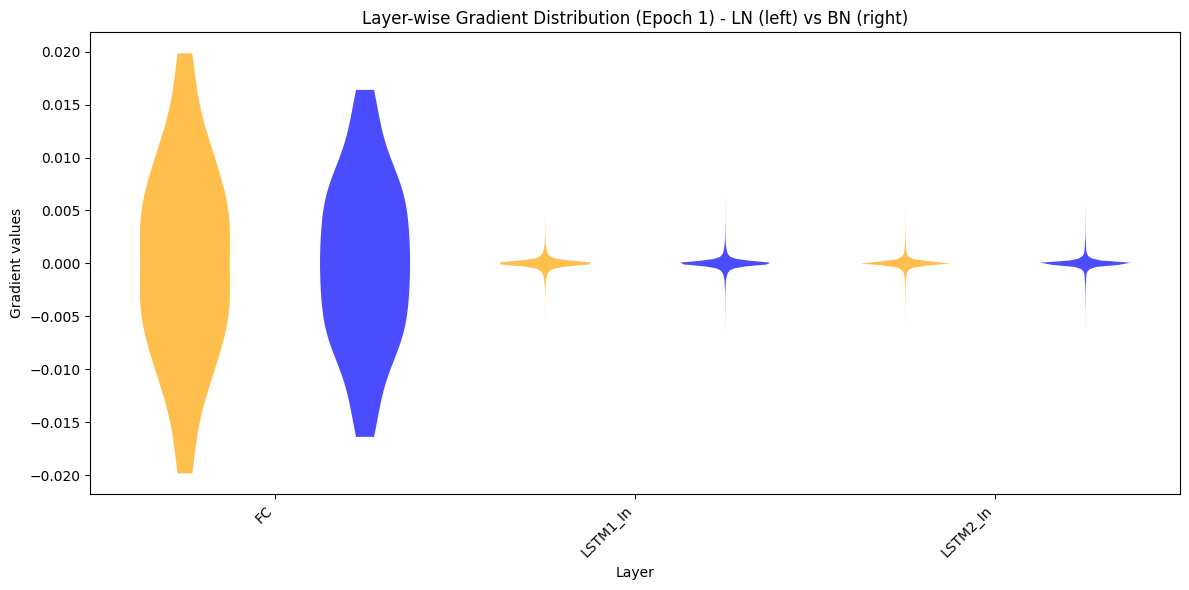

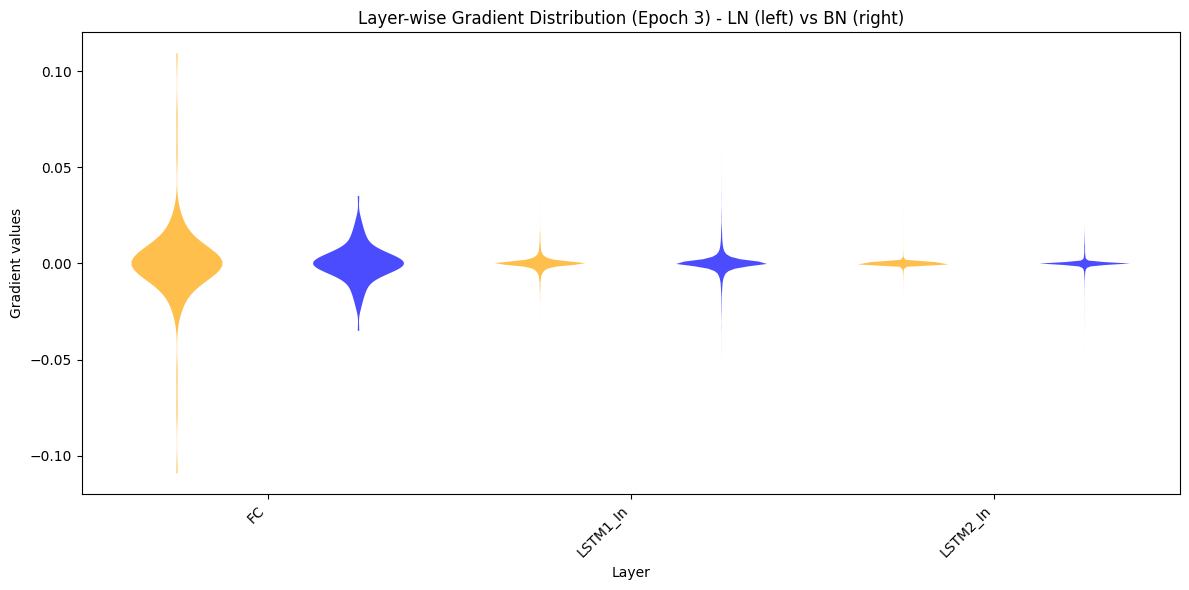

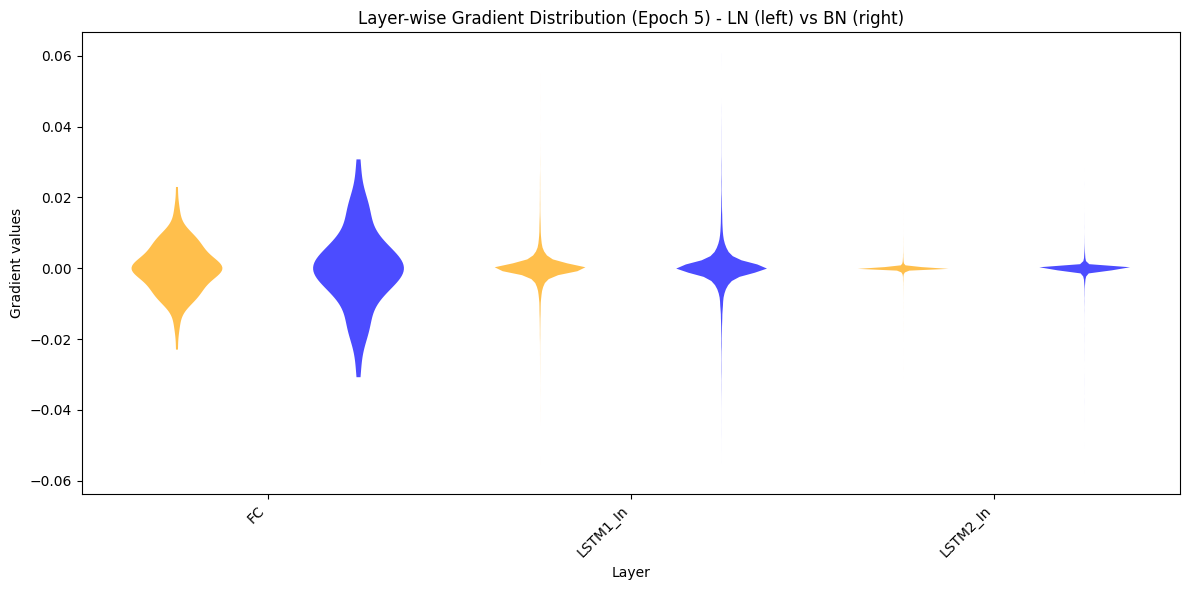


>>> PART B: Running Batch Size Sensitivity Test...
Testing Batch Size: 16

--- Training BATCH | Batch Size: 16 ---
Ep 1: Train Loss 0.558 | Val Acc 0.793
Ep 2: Train Loss 0.397 | Val Acc 0.837

--- Training LAYER | Batch Size: 16 ---
Ep 1: Train Loss 0.558 | Val Acc 0.817
Ep 2: Train Loss 0.355 | Val Acc 0.840
Testing Batch Size: 32

--- Training BATCH | Batch Size: 32 ---
Ep 1: Train Loss 0.576 | Val Acc 0.769
Ep 2: Train Loss 0.421 | Val Acc 0.824

--- Training LAYER | Batch Size: 32 ---
Ep 1: Train Loss 0.578 | Val Acc 0.786
Ep 2: Train Loss 0.387 | Val Acc 0.833
Testing Batch Size: 64

--- Training BATCH | Batch Size: 64 ---
Ep 1: Train Loss 0.593 | Val Acc 0.761
Ep 2: Train Loss 0.428 | Val Acc 0.809

--- Training LAYER | Batch Size: 64 ---
Ep 1: Train Loss 0.614 | Val Acc 0.754
Ep 2: Train Loss 0.515 | Val Acc 0.798
Testing Batch Size: 128

--- Training BATCH | Batch Size: 128 ---
Ep 1: Train Loss 0.639 | Val Acc 0.661
Ep 2: Train Loss 0.516 | Val Acc 0.767

--- Training LAYER |

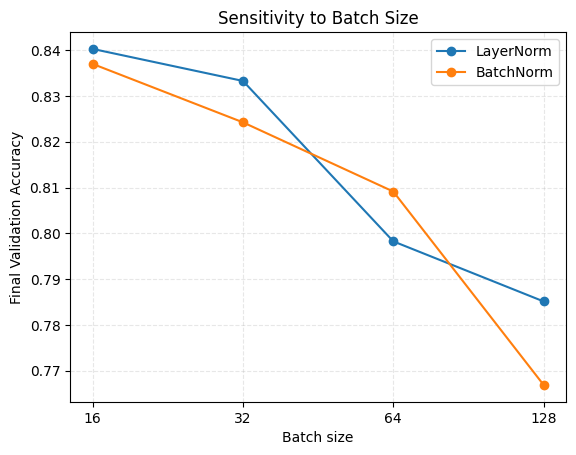


>>> All experiments completed!


In [ ]:
if __name__ == "__main__":


    print(">>> PART A: Running Main Comparison (BN vs LN)...")
    EPOCHS = 5

    hist_bn, snaps_bn = train_model('batch', batch_size=64, epochs=EPOCHS, capture_grads=True)
    hist_ln, snaps_ln = train_model('layer', batch_size=64, epochs=EPOCHS, capture_grads=True)

    print("\n>>> Generating Comparison Plots...")
    plot_combined_loss(hist_bn, hist_ln, save_prefix="IMDB")
    plot_combined_accuracy(hist_bn, hist_ln, save_prefix="IMDB")
    plot_global_grad_norm(hist_bn, "BatchNorm", save_name="grad_norm_IMDB.png")
    plot_global_grad_norm(hist_ln, "LayerNorm", save_name="grad_norm_IMDB.png")

    if len(snaps_bn) > 0:
        plot_layer_grad_violin(snaps_ln, snaps_bn, save_name="IMDB_violin")

    print("\n>>> PART B: Running Batch Size Sensitivity Test...")
    batch_sizes = [8, 16, 32, 64, 128] 
    results_by_batch = {}

    for bs in batch_sizes:
        print(f"Testing Batch Size: {bs}")
        h_bn, _ = train_model('batch', batch_size=bs, epochs=2, capture_grads=False)
        h_ln, _ = train_model('layer', batch_size=bs, epochs=2, capture_grads=False)

        results_by_batch[bs] = {
            "batchnorm": h_bn["val_acc"][-1],
            "layernorm": h_ln["val_acc"][-1]
        }

    plot_sensitivity_batch_size(results_by_batch, save_name="IMDB_sensitivity.png")

    print("\n>>> All experiments completed!")

In [ ]:
print("\n>>> PART B: Running Batch Size Sensitivity Test...")
batch_sizes = [8, 16, 32, 64, 128] 
results_by_batch = {}

for bs in batch_sizes:
    print(f"Testing Batch Size: {bs}")
    h_bn, _ = train_model('batch', batch_size=bs, epochs=2, capture_grads=False)
    h_ln, _ = train_model('layer', batch_size=bs, epochs=2, capture_grads=False)

    results_by_batch[bs] = {
        "batchnorm": h_bn["val_acc"][-1],
        "layernorm": h_ln["val_acc"][-1]
    }


>>> PART B: Running Batch Size Sensitivity Test...
Testing Batch Size: 8

--- Training BATCH | Batch Size: 8 ---
Ep 1: Train Loss 0.554 | Val Acc 0.827
Ep 2: Train Loss 0.323 | Val Acc 0.871

--- Training LAYER | Batch Size: 8 ---
Ep 1: Train Loss 0.539 | Val Acc 0.801
Ep 2: Train Loss 0.321 | Val Acc 0.863
Testing Batch Size: 16

--- Training BATCH | Batch Size: 16 ---
Ep 1: Train Loss 0.558 | Val Acc 0.793
Ep 2: Train Loss 0.397 | Val Acc 0.837

--- Training LAYER | Batch Size: 16 ---
Ep 1: Train Loss 0.558 | Val Acc 0.817
Ep 2: Train Loss 0.355 | Val Acc 0.840
Testing Batch Size: 32

--- Training BATCH | Batch Size: 32 ---
Ep 1: Train Loss 0.576 | Val Acc 0.769
Ep 2: Train Loss 0.421 | Val Acc 0.824

--- Training LAYER | Batch Size: 32 ---
Ep 1: Train Loss 0.578 | Val Acc 0.786
Ep 2: Train Loss 0.387 | Val Acc 0.833
Testing Batch Size: 64

--- Training BATCH | Batch Size: 64 ---
Ep 1: Train Loss 0.593 | Val Acc 0.761
Ep 2: Train Loss 0.428 | Val Acc 0.809

--- Training LAYER | Batc

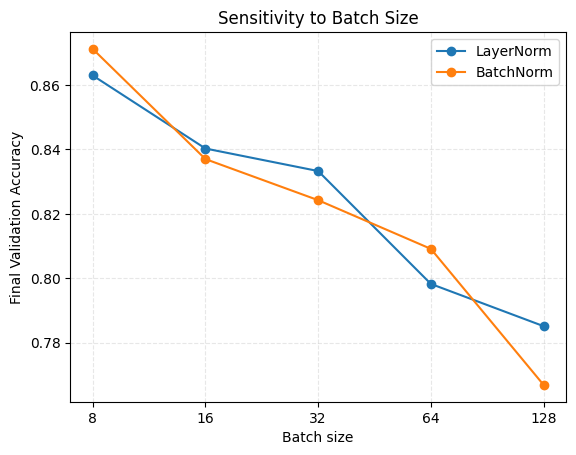


>>> All experiments completed!


In [ ]:
plot_sensitivity_batch_size(results_by_batch, save_name="IMDB_sensitivity.png")

print("\n>>> All experiments completed!")